In [131]:
import pandas as pd
import numpy as np
from typing import Optional, Dict, Any
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [132]:
import pandas as pd
import numpy as np
from typing import Optional, Dict, Any
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_regression(method: str = 'ols',
                     degree: int = 1,
                     scaler: Optional[str] = None,
                     df: Optional[pd.DataFrame] = None,
                     test_size: float = 0.20,
                     shuffle: bool = True,
                     random_state: int = 0,
                     # Parámetros específicos para SGD
                     sgd_max_iter: int = 1000,
                     sgd_learning_rate: str = 'invscaling',
                     sgd_eta0: float = 0.001       # tasa de aprendizaje inicial (si learning_rate='constant' es usada como eta0)
                    ) -> Dict[str, Any]:
    method = method.lower()
    if method not in ('ols', 'sgd'):
        raise ValueError("method debe ser 'ols' o 'sgd'")

    # seleccionar dataframe
    if df is None:
        try:
            df = globals()['dataset']
        except Exception as e:
            raise ValueError("No se proporcionó 'df' y no existe variable global 'dataset'.") from e

    # X: todas las columnas menos la última ; y: última columna
    X = df.iloc[:, :-1].values    # mantén la forma (n_samples, n_features)
    y = df.iloc[:, -1].values     # 1D target

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=shuffle, random_state=random_state
    )

    # polinomio (aplica sobre la matriz tal cual; PolynomialFeatures acepta 2D)
    poly = None
    if degree > 1:
        poly = PolynomialFeatures(degree=degree, include_bias=True)
        X_train_trans = poly.fit_transform(X_train)
        X_test_trans = poly.transform(X_test)
    else:
        X_train_trans = X_train.copy()
        X_test_trans = X_test.copy()

    # escalamiento sobre X solamente (opcional). No escalar y por defecto.
    scaler_obj = None
    if scaler is not None:
        s = scaler.lower()
        if s == 'standard':
            scaler_obj = StandardScaler()
        elif s == 'robust':
            scaler_obj = RobustScaler()
        else:
            raise ValueError("scaler debe ser None, 'standard' o 'robust'.")
        X_train_scaled = scaler_obj.fit_transform(X_train_trans)
        X_test_scaled = scaler_obj.transform(X_test_trans)
    else:
        X_train_scaled = X_train_trans
        X_test_scaled = X_test_trans

    # modelado
    if method == 'ols':
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)   # y en 1D
    else:
        sgd = SGDRegressor(
                           max_iter=sgd_max_iter,
                           learning_rate=sgd_learning_rate,
                           eta0=sgd_eta0,
                           random_state=random_state,
                           tol=None)   # igual que tu otro notebook
        sgd.fit(X_train_scaled, y_train)
        model = sgd

    # predicción y métricas (se comparan en la escala original de y)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultado = {
        'model': model,
        'method': method,
        'degree': degree,
        'poly': poly,
        'scaler_obj': scaler_obj,
        'X_train': X_train,
        'X_test': X_test,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'mse': mse,
        'r2': r2
    }

    print(f"[{method.upper()}] degree={degree} | scaler={scaler} -> MSE: {mse:.6f}, R2: {r2:.6f}")

    return resultado


In [133]:

def plot_regression_result(res, plot_X_vs_y_pred=True, filename=None):
    """
    Si plot_X_vs_y_pred == True: grafica X_test vs y_pred (ordena X para curvas polinomiales).
    Si False: grafica y_test vs y_pred (scatter de residuales).
    """
    X_test = res['X_test']
    y_test = res['y_test']
    y_pred = res['y_pred']
    method = res['method'].upper()
    degree = res['degree']
    mse = res['mse']
    r2 = res['r2']

    plt.figure(figsize=(6,5))
    if plot_X_vs_y_pred:
        # Si X tiene una sola columna, ploteamos X vs y_pred y ordenamos por X
        if X_test.ndim == 2 and X_test.shape[1] == 1:
            Xvec = X_test.ravel()
            order = np.argsort(Xvec)
            plt.scatter(Xvec, y_test, alpha=0.6, label='Datos de prueba')
            plt.plot(Xvec[order], y_pred[order], linewidth=2, label='Predicción')
            plt.xlabel('X')
        else:
            # multivar: dibujar scatter de y_test vs y_pred (no hay "X" simple para curva)
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.xlabel('y_test (real)')
            plt.ylabel('y_pred (predicho)')
    else:
        plt.scatter(y_test, y_pred, alpha=0.6)
        mn = min(y_test.min(), y_pred.min())
        mx = max(y_test.max(), y_pred.max())
        plt.plot([mn, mx], [mn, mx], linestyle='--')
        plt.xlabel('y_test (real)')
        plt.ylabel('y_pred (predicho)')

    plt.title(f"{method} degree={degree} | MSE={mse:.4f} R2={r2:.4f}")
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.tight_layout()
    plt.show()

# 📘 Práctica: Regresión Polinomial — Programa 1

## 🧩 Especificaciones del Programa 1

### I. Dataset
- Utiliza el dataset **`datos.csv`**.

---

### II. División de los datos
- Divide el dataset en:
  - **70%** para **entrenamiento**
  - **30%** para **pruebas**
- Parámetros:
  - `shuffle = True`
  - `random_state = 0`

---

### III. Modelos a implementar
Usando las bibliotecas de *scikit-learn*, realiza las siguientes regresiones:

#### 🔹 Regresiones con OLS (Ordinary Least Squares)
1. **Regresión lineal (OLS)**
2. **Regresión polinomial de grado 2 (OLS)**
3. **Regresión polinomial de grado 3 (OLS)**

#### 🔹 Regresiones con SGD (Stochastic Gradient Descent)
4. **Regresión lineal con SGD**
5. **Regresión polinomial de grado 2 con SGD**
6. **Regresión polinomial de grado 3 con SGD**

---

### IV. Entrada
- Archivo: **`datos.csv`**
- Para los modelos con **SGD**, también se debe recibir:
  - **Número de iteraciones (`max_iter`)**
  - **Tasa de regularización (`α`, alpha)**

---

### V. Salida
Cada regresión debe generar:

1. **Una gráfica** con los siguientes elementos:
   - Distribución de los datos de prueba.
   - Curva de predicción `(X_test, y_pred)`  
     *(En el caso de regresión polinomial, ordenar los datos antes de graficar la curva predicha).*

2. **Resumen de los resultados**, mostrando:
   - Error cuadrático medio (MSE)
   - Coeficiente de determinación (R²)

---


In [134]:
datos = pd.read_csv('datos.csv')

#### 🔹 Regresiones con OLS (Ordinary Least Squares)
1. **Regresión lineal (OLS)**
2. **Regresión polinomial de grado 2 (OLS)**
3. **Regresión polinomial de grado 3 (OLS)**


In [135]:
ols_1_p1 = train_regression(method='ols', degree=1, df=datos, test_size=0.3, shuffle=True, random_state=0)
ols_2_p1 = train_regression(method='ols', degree=2, df=datos, test_size=0.3, shuffle=True, random_state=0)
ols_3_p1 = train_regression(method='ols', degree=3, df=datos, test_size=0.3, shuffle=True, random_state=0)

[OLS] degree=1 | scaler=None -> MSE: 296.094587, R2: 0.719805
[OLS] degree=2 | scaler=None -> MSE: 352.437384, R2: 0.666487
[OLS] degree=3 | scaler=None -> MSE: 8.487854, R2: 0.991968


#### 🔹 Regresiones con SGD (Stochastic Gradient Descent)
4. **Regresión lineal con SGD**
5. **Regresión polinomial de grado 2 con SGD**
6. **Regresión polinomial de grado 3 con SGD**


In [136]:
sgd_1_p1 = train_regression(method='sgd', degree=1, df=datos, test_size=0.3,
                         shuffle=True, random_state=0,
                         sgd_max_iter=10000, sgd_learning_rate='constant', sgd_eta0=10e-8)
sgd_2_p1 = train_regression(method='sgd', degree=2, df=datos, test_size=0.3,
                         shuffle=True, random_state=0,
                         sgd_max_iter=10000, sgd_learning_rate='constant', sgd_eta0=10e-8)
sgd_3_p1 = train_regression(method='sgd', degree=3, df=datos, test_size=0.3,
                         shuffle=True, random_state=0,
                         sgd_max_iter=10000, sgd_learning_rate='constant', sgd_eta0=10e-8)


[SGD] degree=1 | scaler=None -> MSE: 554.963137, R2: 0.474837
[SGD] degree=2 | scaler=None -> MSE: 872.467128, R2: 0.174382
[SGD] degree=3 | scaler=None -> MSE: 12.620635, R2: 0.988057


,x,y
0,-3.292157,-44.608971
1,-0.936214,0.623178
2,-3.602674,-58.873048
3,-0.850265,-6.057589
4,2.309657,-3.967128


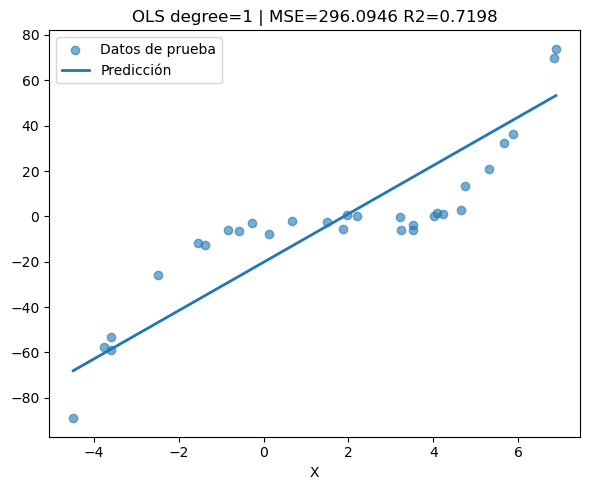

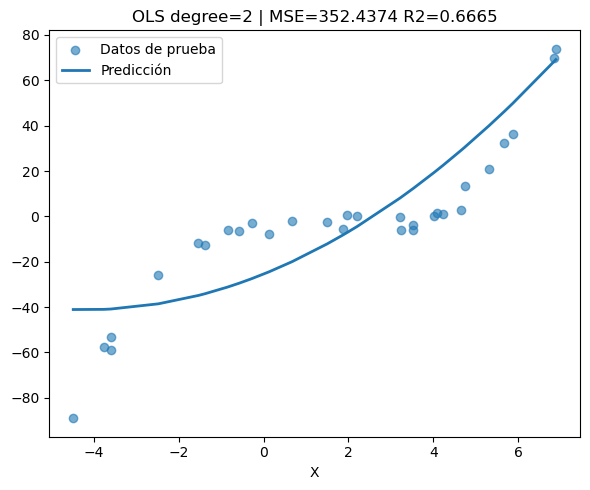

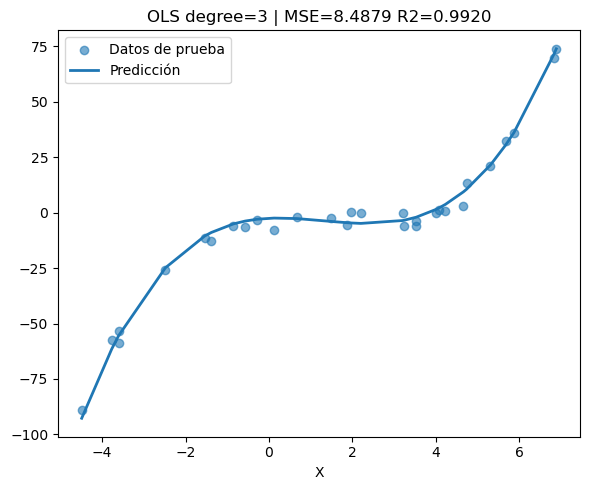

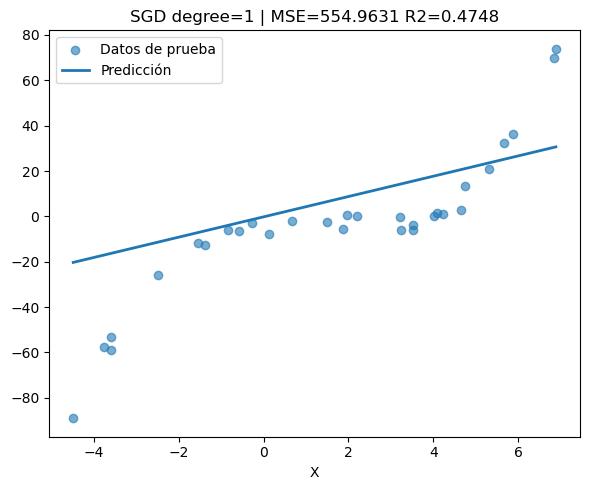

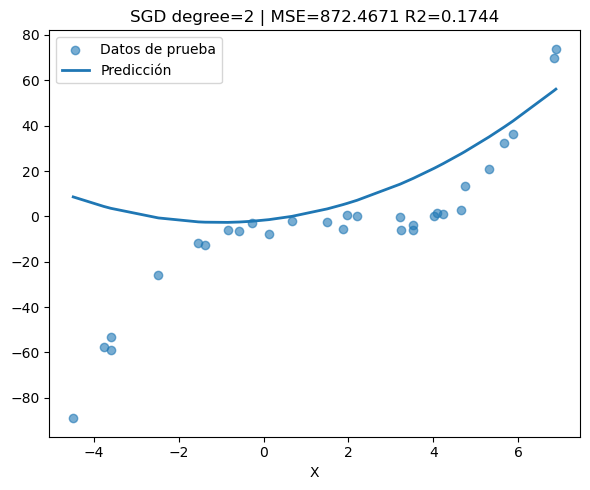

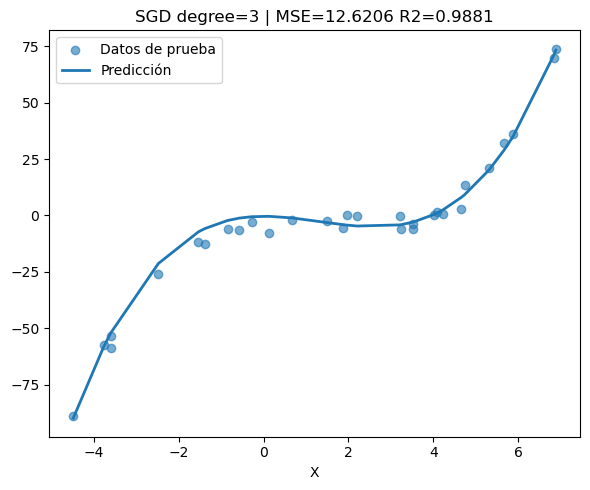

In [137]:

datos = pd.read_csv('datos.csv')

display(datos.head())

results = []
results.append(ols_1_p1)
results.append(ols_2_p1)
results.append(ols_3_p1)
results.append(sgd_1_p1)
results.append(sgd_2_p1)
results.append(sgd_3_p1)

# Graficas y guardado
for i, res in enumerate(results, start=1):
    plot_regression_result(res)


## 🧩 Especificaciones del Programa 2

### I. Dataset
- Utiliza el dataset **`cal_housing.csv`**.  
- Las **primeras columnas** son las características (*features*) y la **última columna** es el **target** (variable a predecir).

---

### II. División de los datos
- Divide los datos en:
  - **80%** para **entrenamiento**
  - **20%** para **pruebas**
- Parámetros:
  - `shuffle = True`
  - `random_state = 0`

---

### III. Modelos a implementar (OLS)
Usando las bibliotecas de *scikit-learn*, realiza las siguientes regresiones:

1. **Regresión Lineal**
2. **Regresión Polinomial de grado 2**
3. **Regresión Polinomial de grado 2 con escalamiento estándar**
4. **Regresión Polinomial de grado 2 con escalamiento robusto**
5. **Regresión Polinomial de grado 3**
6. **Regresión Polinomial de grado 3 con escalamiento estándar**
7. **Regresión Polinomial de grado 3 con escalamiento robusto**

---

### IV. Entrada
- Archivo: **`cal_housing.csv`**

---

### V. Salida
- **Resumen de los resultados**, mostrando para cada modelo:
  - Error cuadrático medio (MSE)
  - Coeficiente de determinación (R²)
- El formato del resumen debe seguir el ejemplo mostrado en la práctica (ver Figura 3).

---

In [138]:
cal_housing = pd.read_csv('cal_housing.csv')

### III. Modelos a implementar (OLS)
Usando las bibliotecas de *scikit-learn*, realiza las siguientes regresiones:

1. **Regresión Lineal**
2. **Regresión Polinomial de grado 2**
3. **Regresión Polinomial de grado 2 con escalamiento estándar**
4. **Regresión Polinomial de grado 2 con escalamiento robusto**
5. **Regresión Polinomial de grado 3**
6. **Regresión Polinomial de grado 3 con escalamiento estándar**
7. **Regresión Polinomial de grado 3 con escalamiento robusto**


In [139]:
ols_1_p2 = train_regression(method='ols', degree=1, df=cal_housing, test_size=0.2, shuffle=True, random_state=0)
ols_2_p2 = train_regression(method='ols', degree=2, df=cal_housing, test_size=0.2, shuffle=True, random_state=0)
ols_2_p2 = train_regression(method='ols', degree=2, df=cal_housing, test_size=0.2, shuffle=True, random_state=0, scaler='standard')
ols_2_p2 = train_regression(method='ols', degree=2, df=cal_housing, test_size=0.2, shuffle=True, random_state=0, scaler='robust')
ols_1_p2 = train_regression(method='ols', degree=3, df=cal_housing, test_size=0.2, shuffle=True, random_state=0)
ols_2_p2 = train_regression(method='ols', degree=3, df=cal_housing, test_size=0.2, shuffle=True, random_state=0, scaler='standard')
ols_2_p2 = train_regression(method='ols', degree=3, df=cal_housing, test_size=0.2, shuffle=True, random_state=0, scaler='robust')

[OLS] degree=1 | scaler=None -> MSE: 4853781771.947975, R2: 0.627765
[OLS] degree=2 | scaler=None -> MSE: 4076152917.009423, R2: 0.687401
[OLS] degree=2 | scaler=standard -> MSE: 4076152877.920670, R2: 0.687401
[OLS] degree=2 | scaler=robust -> MSE: 4076152877.920571, R2: 0.687401
[OLS] degree=3 | scaler=None -> MSE: 4136315752.551249, R2: 0.682787
[OLS] degree=3 | scaler=standard -> MSE: 4103523449.505999, R2: 0.685302
[OLS] degree=3 | scaler=robust -> MSE: 4103523449.507183, R2: 0.685302
